데이터 수집 및 탐색

In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [33]:
# 현재 작업 디렉토리
base_dir = os.getcwd()

# 데이터 저장 경로
save_path = os.path.join(base_dir, 'dataset', 'kospi_data.csv')


In [34]:
# KOSPI 데이터 수집
kospi_data = yf.download('^KS11', start='2015-01-01', end='2025-01-01')

# 데이터 저장
kospi_data.to_csv(save_path)


[*********************100%***********************]  1 of 1 completed


In [35]:
# 데이터 로드
kospi_data = pd.read_csv(save_path, skiprows=2) # 상단의 2행 제거

# 열 이름 수정
kospi_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# 'Date' 열을 날짜 형식으로 변환하고 인덱스로 설정
kospi_data['Date'] = pd.to_datetime(kospi_data['Date'], errors='coerce')
kospi_data.set_index('Date', inplace=True)

# 데이터 타입 변환
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    kospi_data[col] = pd.to_numeric(kospi_data[col], errors='coerce')
    
# 데이터 확인
print(kospi_data.info())
print(kospi_data.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2454 entries, 2015-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2454 non-null   float64
 1   High    2454 non-null   float64
 2   Low     2454 non-null   float64
 3   Open    2454 non-null   float64
 4   Volume  2454 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 115.0 KB
None
                  Close         High          Low         Open  Volume
Date                                                                  
2015-01-02  1926.439941  1929.150024  1909.670044  1914.239990  258800
2015-01-05  1915.750000  1921.959961  1903.369995  1921.959961  313400
2015-01-06  1882.449951  1900.020020  1877.380005  1895.479980  303700
2015-01-07  1883.829956  1887.599976  1876.270020  1878.900024  280500
2015-01-08  1904.650024  1907.229980  1891.770020  1895.849976  262200


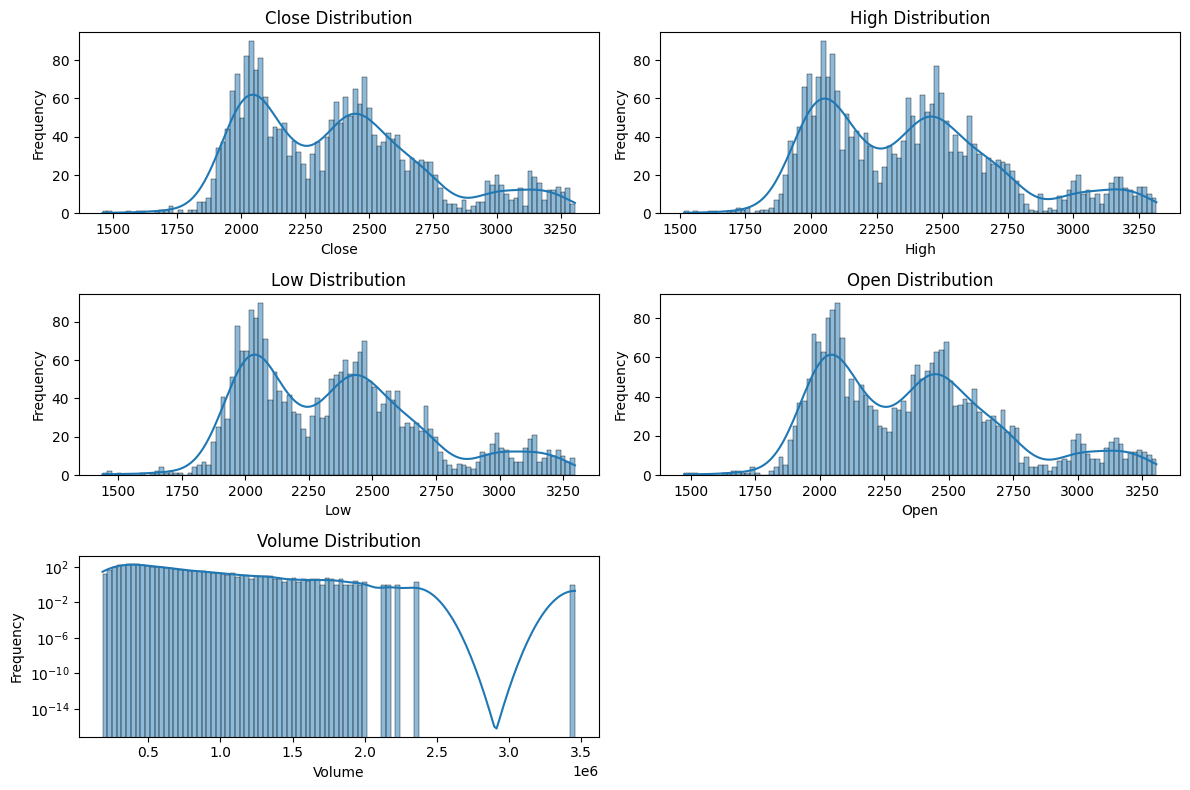

In [80]:
# 데이터 분포 확인
plt.figure(figsize=(12,8))
variables = ['Close', 'High', 'Low', 'Open', 'Volume']
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.histplot(kospi_data[var], bins=100, kde=True)
    plt.title(f'{var} Distribution')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    if var == 'Volume':
        plt.yscale('log')  # 거래량의 경우 로그 스케일 적용
plt.tight_layout()
plt.show()


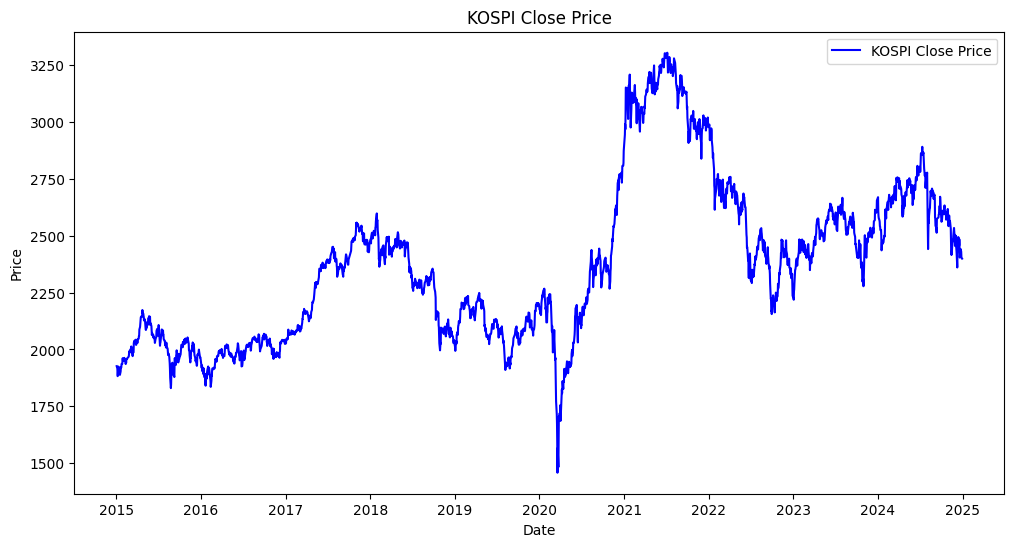

In [36]:
# 데이터 시각화: 종가(Close)
plt.figure(figsize=(12,6))
plt.plot(kospi_data['Close'], label='KOSPI Close Price' ,color='blue')
plt.title('KOSPI Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


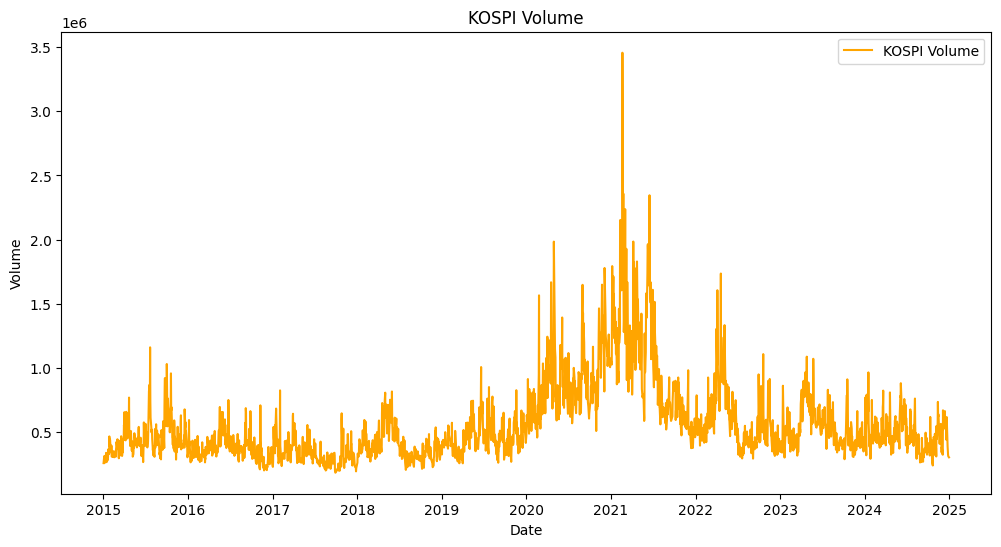

In [37]:
# 데이터 시각화: 거래량(Volume)
plt.figure(figsize=(12,6))
plt.plot(kospi_data['Volume'], label='KOSPI Volume' ,color='orange')
plt.title('KOSPI Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


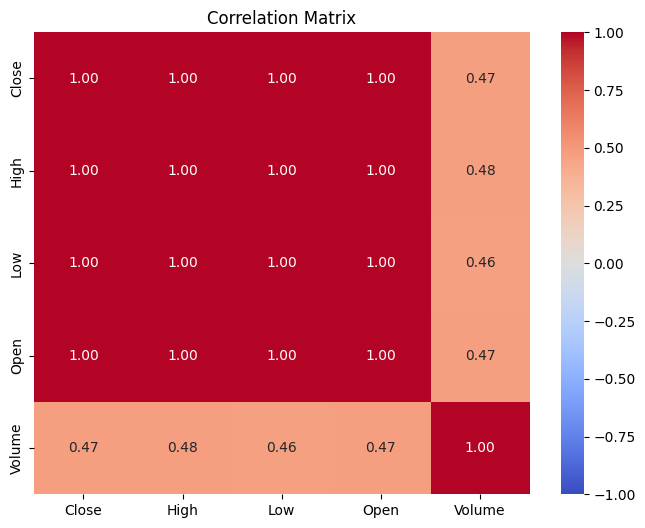

In [74]:
# 상관 관계
corr_matrix = kospi_data.corr()

# 히트맵
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


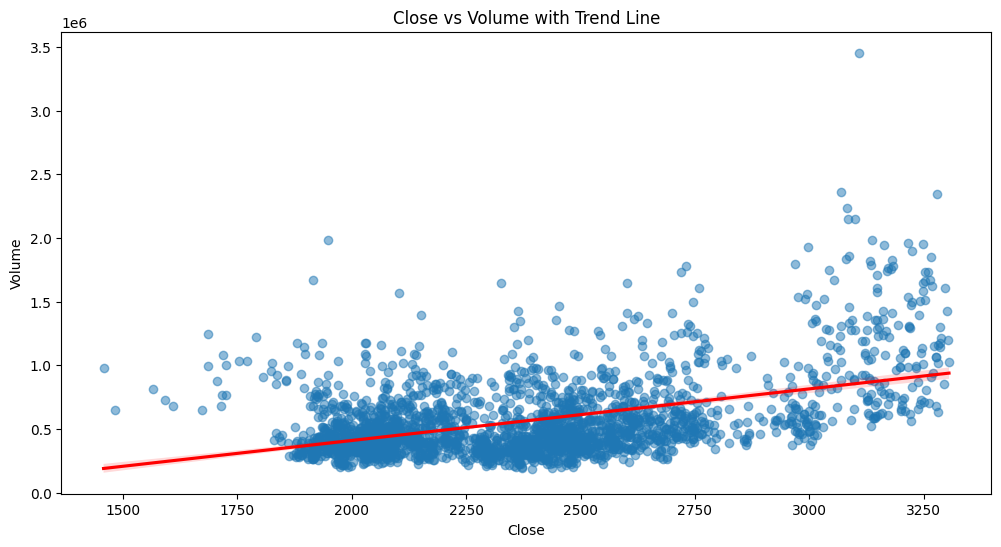

In [83]:
# 종가와 거래량의 상관 관계
plt.figure(figsize=(12,6))
sns.regplot(x=kospi_data['Close'], y=kospi_data['Volume'], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.title('Close vs Volume with Trend Line')
plt.xlabel('Close')
plt.ylabel('Volume')
plt.show()


데이터 전처리

In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 준비
close_prices = kospi_data['Close'].values # 'Close' 열의 값을 배열로 변환
n_steps = 30 # 과거 30일 데이터를 기반으로 예측

# 데이터 슬라이싱 함수
def create_dataset(data, n_steps):  # look_back = n_steps
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps]) # 과거 n_steps(30일) 데이터를 기반으로 예측
        y.append(data[i+n_steps]) # 다음날 종가를 예측
    return np.array(X), np.array(y)


In [39]:
# 정규화
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1,1)) # 1차원 배열을 2차원 배열로 변환

# 시계열 데이터 생성
X, y = create_dataset(close_prices_scaled, n_steps)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 형태 확인
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)


X_train.shape: (1939, 30, 1)
X_test.shape: (485, 30, 1)
y_train.shape: (1939, 1)
y_test.shape: (485, 1)


LSTM모델 학습 및 평가

In [64]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 입력 데이터 형태 확인
print("X_train before reshape.shape:", X_train.shape)
print("X_test before reshape.shape:", X_test.shape)

# 3D 데이터 형태로 변환
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) # (samples, time steps, features)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train after reshape.shape:", X_train.shape)
print("X_test after reshape.shape:", X_test.shape)

print("Samples:", X_train.shape[0])


X_train before reshape.shape: (1939, 30, 1)
X_test before reshape.shape: (485, 30, 1)
X_train after reshape.shape: (1939, 30, 1)
X_test after reshape.shape: (485, 30, 1)
Samples: 1939


In [65]:

# 모델 설계
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    # 'relu': 활성화 함수 
    # return_sequences=True: 출력 시퀀스를 반환하여 다음 LSTM 층에 전달
    # input_shape=(X_train.shape[1], X_train.shape[2]): 입력 데이터의 형태
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


c:\New_Ai_project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1601 - val_loss: 0.0025
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0076 - val_loss: 0.0014
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0044 - val_loss: 9.5952e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss:

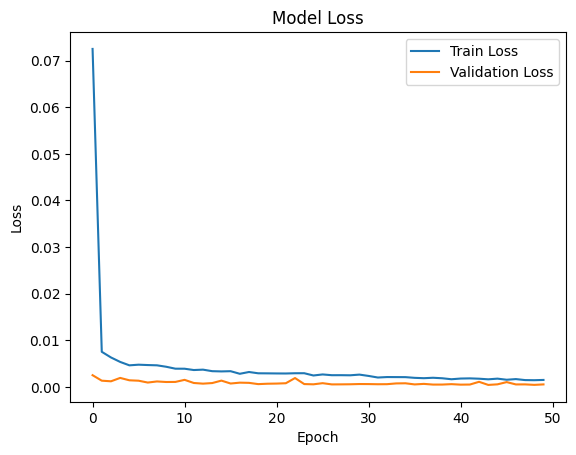

In [67]:
# 학습 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test Loss: 0.0005634003318846226
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


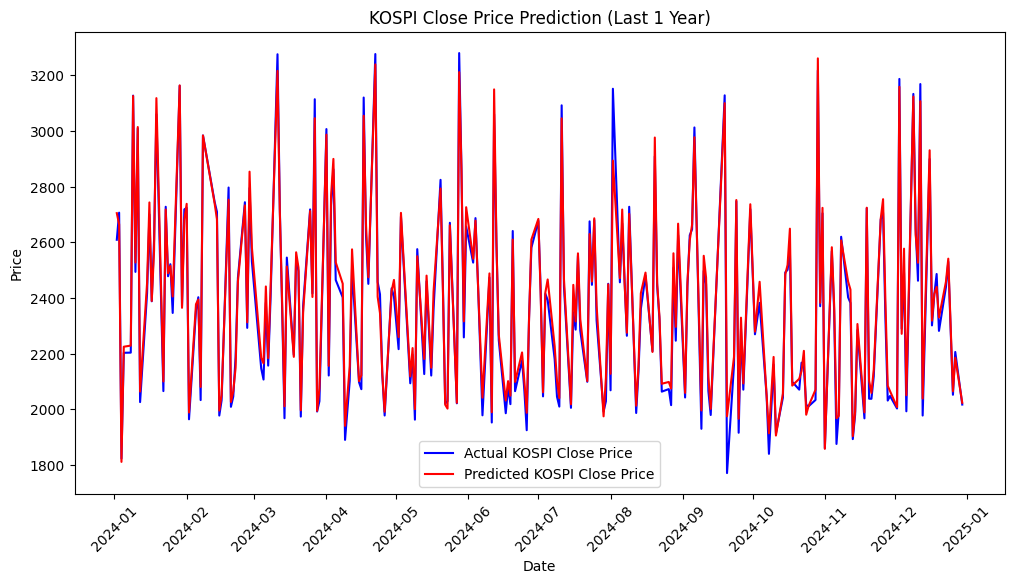

In [68]:
# 모델 평가
loss = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", loss)

# 예측
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred) # 예측 결과를 원래 데이터 범위로 변환
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)) # y_test도 원래 데이터 범위로 변환

# 마지막 1년 데이터 필터링
last_1_year_dates = test_dates[test_dates >= "2024-01-01"]  
last_1_year_y_test = y_test_rescaled[-len(last_1_year_dates):]  # 마지막 1년 테스트 데이터
last_1_year_y_pred = y_pred_rescaled[-len(last_1_year_dates):]  # 마지막 1년 예측 데이터

# 예측 결과 시각화 (마지막 1년 데이터)
plt.figure(figsize=(12, 6))
plt.plot(last_1_year_dates, last_1_year_y_test, label='Actual KOSPI Close Price', color='blue')
plt.plot(last_1_year_dates, last_1_year_y_pred, label='Predicted KOSPI Close Price', color='red')
plt.title('KOSPI Close Price Prediction (Last 1 Year)')
plt.xlabel('Date')
plt.ylabel('Price')

# x축 날짜 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 월 단위 간격
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 표시
plt.xticks(rotation=45)

plt.legend()
plt.show()



In [71]:
# 모델 성능 분석: MAE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print("MAE:", mae)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print("RMSE:", rmse)

# R2
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print("R2:", r2)


MAE: 33.50129671391753
RMSE: 43.854017099586564
R2: 0.9837264812270898


In [72]:
# 모델 저장
model.save('./model/kospi_prediction_model.h5')